<a href="https://colab.research.google.com/github/HeyLaxmi/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [37]:
!pip install pandas==0.23.4

     |████████████████████████████████| 8.9MB 4.8MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=0.24.0, but you'll have pandas 0.23.4 which is incompatible.
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [5]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=489.09474575296053, mobile=False), User(purchased=True, time_on_site=33.245310133935746, mobile=True), User(purchased=False, time_on_site=120.94473805368524, mobile=True), User(purchased=True, time_on_site=248.1923873541026, mobile=True), User(purchased=False, time_on_site=133.50043466875866, mobile=True), User(purchased=True, time_on_site=177.07209476486037, mobile=True), User(purchased=False, time_on_site=143.07448028163057, mobile=True), User(purchased=True, time_on_site=16.40429045905646, mobile=True), User(purchased=False, time_on_site=151.1449061780854, mobile=True), User(purchased=True, time_on_site=242.83901607896172, mobile=True)]


In [9]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,489.094746,False
1,True,33.245310,True
2,False,120.944738,True
3,True,248.192387,True
4,False,133.500435,True


In [10]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.429106165386618,6.681051363464444,6.747308850763309,7.222035798214186,7.240131283247547,7.580785907424264,8.133331415349144,8.342171766764386,8.960871673101407,9.185650331248102,9.796594349679651,9.890047312419572,10.692049317254154,11.043568921009673,11.552442040364859,13.048895016474496,13.118166735440578,13.177275190555285,13.35961949020927,13.55267801530942,14.085818467787382,14.25212390514733,14.416908437384766,14.510007614762316,14.521025470401515,14.541702932762362,14.881651273043174,15.155100692770754,15.625943442849685,15.705463279238673,16.09091403507465,16.234038815620785,16.40429045905646,16.429103386018426,16.75428970967247,16.77639554776429,16.784329052933117,18.190703955456947,18.191016480642134,18.199724903561528,...,498.86610411988875,502.022374511655,503.69264635884343,505.03951896025023,506.46989844302,507.46602719438226,517.6126573494223,517.7907293290651,517.9403041414275,519.88314465395,519.9503157994532,522.1842653599238,527.7986897631903,529.2665994191062,530.9566618740491,541.8425311425627,542.0818869094925,542.2202266443002,543.0273059026101,545.871036662369,546.4605086074806,552.3547238492928,553.0545696047067,568.6183551278024,572.419934945028,573.5475938179382,575.0583311464951,575.3240707517035,575.5385647004451,578.1332080147945,583.71745249668,584.6345341487446,584.7206114335743,585.4765445980466,587.2923267719166,587.3823501639167,593.9868022225279,595.6864848761902,596.8605434727674,597.2660103375712
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,1,1,1,0,1,1,...,0,1,0,0,0,1,0,1,0,0,0,1,1,1,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,1,1,0,1,0,0,0,0,0
True,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,1,1,0,0,0,0,1,0,0,...,1,0,1,1,1,0,1,0,1,1,1,0,0,0,1,0,1,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,1,0,1,1,1,1,1


In [11]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.837, 123.796]","(123.796, 242.164]","(242.164, 360.531]","(360.531, 478.899]","(478.899, 597.266]"
purchased,,,,,
False,259,225,97,29,21
True,107,147,75,15,25


In [12]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.837, 123.796]","(123.796, 242.164]","(242.164, 360.531]","(360.531, 478.899]","(478.899, 597.266]"
purchased,,,,,
False,0.70765,0.604839,0.563953,0.659091,0.456522
True,0.29235,0.395161,0.436047,0.340909,0.543478


In [13]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.724,0.6
True,0.276,0.4


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [17]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
import pandas as pd
df = pd.read_csv('persons.csv')

ParserError: ignored

In [18]:
import random
dir(random)

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [19]:
!wget https://raw.githubusercontent.com/HeyLaxmi/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv
import pandas as pd
df = pd.read_csv('persons.csv.1')
df.head()

--2019-07-10 22:52:34--  https://raw.githubusercontent.com/HeyLaxmi/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17574 (17K) [text/plain]
Saving to: ‘persons.csv.8’

persons.csv.8       100%[===================>]  17.16K  --.-KB/s    in 0.007s  

2019-07-10 22:52:34 (2.42 MB/s) - ‘persons.csv.8’ saved [17574/17574]



,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [20]:
age_groups = pd.cut(df['age'],6, precision=0)# 5 equal-sized bins
weight_groups = pd.cut(df['weight'], 5, precision=0)
exercise_groups = pd.cut(df['exercise_time'], 5, precision=0)
pd.crosstab([age_groups,weight_groups],exercise_groups, rownames= ['Age(years)', 'Weight (lbs)'], colnames = ["Exercise_Times"])


Exercise_Times               (-0.0, 60.0]       ...        (240.0, 300.0]
Age(years)   Weight (lbs)                       ...                      
(18.0, 28.0] (100.0, 129.0]             8       ...                    23
             (129.0, 158.0]             3       ...                    11
             (158.0, 188.0]             6       ...                     2
             (188.0, 217.0]            13       ...                     0
             (217.0, 246.0]             7       ...                     0
(28.0, 39.0] (100.0, 129.0]             9       ...                    21
             (129.0, 158.0]            11       ...                    19
             (158.0, 188.0]            12       ...                     2
             (188.0, 217.0]            16       ...                     0
             (217.0, 246.0]             5       ...                     0
(39.0, 49.0] (100.0, 129.0]             3       ...                    34
             (129.0, 158.0]             8       ...                    18
             (158.0, 188.0]             7       ...                     5
             (188.0, 217.0]            10       ...                     0
             (217.0, 246.0]             8       ...                     0
(49.0, 59.0] (100.0, 129.0]             8       ...                    26
             (129.0, 158.0]             3       ...                    22
             (158.0, 188.0]             9       ...                     1
             (188.0, 217.0]             8       ...                     0
             (217.0, 246.0]             1       ...                     0
(59.0, 70.0] (100.0, 129.0]             6       ...                     3
             (129.0, 158.0]             7       ...                     4
             (158.0, 188.0]             9       ...                     0
             (188.0, 217.0]            15       ...                     0
             (217.0, 246.0]             9       ...                     0
(70.0, 80.0] (100.0, 129.0]            19       ...                     0
             (129.0, 158.0]            12       ...                     0
             (158.0, 188.0]            18       ...                     0
             (188.0, 217.0]            14       ...                     0
             (217.0, 246.0]            14       ...                     0

[30 rows x 5 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e6c32b9b0>,
      dtype=object)

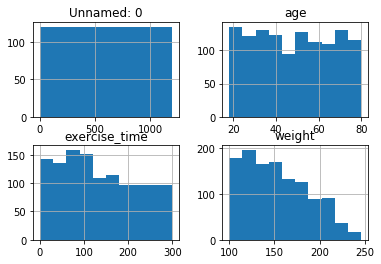

In [21]:
df.hist()

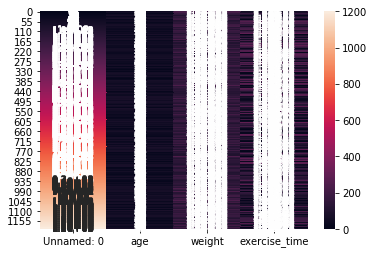

In [23]:
import seaborn as sns
sns.heatmap(df, annot=True)

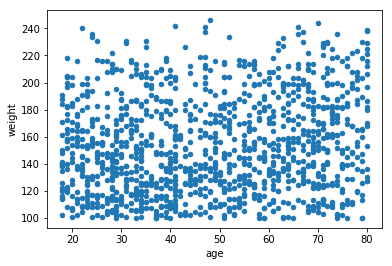

In [24]:
# Satter Plot
df.plot.scatter('age', 'weight');

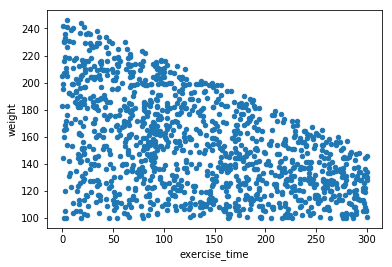

In [25]:
df.plot.scatter('exercise_time', 'weight');

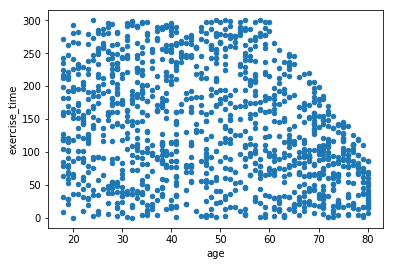

In [26]:
df.plot.scatter('age', 'exercise_time');

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)